# UT2 – Práctica Extra: Caso de estudio de riesgo crediticio y equidad

En esta práctica extra se analiza un caso de **riesgo crediticio** usando el dataset `credit-g`
(German Credit) de OpenML.  
El objetivo es construir un pipeline responsable que combine:

- **Calidad de datos** (detección e imputación de valores faltantes simulados),
- **Modelo predictivo** para clasificar solicitudes de crédito,
- **Análisis de equidad (fairness)** por género en las predicciones.

Se trabaja con un flujo reproducible en scikit-learn, con énfasis en las competencias
de la Unidad Temática 2: *calidad, responsabilidad y ética en el manejo de datos.*

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

In [2]:
# Cargar German Credit desde OpenML
credit = fetch_openml(name="credit-g", version=1, as_frame=True)
df = credit.frame.copy()

print(df.shape)
df.head()

(1000, 21)


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


## 1. Contexto del caso

El dataset describe **solicitudes de crédito** en un banco alemán.
Cada fila representa una persona y la variable objetivo (`class`) indica si se considera
el riesgo como:

- `good`: cliente con buen riesgo crediticio
- `bad`: cliente con alto riesgo (podría entrar en default)

El foco de esta práctica es:
1. Analizar la calidad de los datos.
2. Simular valores faltantes y aplicar imputación contextual.
3. Entrenar un modelo de clasificación.
4. Evaluar si el modelo trata de forma diferente a hombres y mujeres.

In [3]:
df["class"].value_counts()

,count
class,
good,700
bad,300


In [4]:
# Crear variable de género a partir de 'personal_status'
df["gender"] = df["personal_status"].apply(
    lambda x: "male" if "male" in str(x) else "female"
)

df["gender"].value_counts()

,count
gender,
male,1000


In [5]:
# Copia para simular valores faltantes
df_missing = df.copy()

# Simular 10% de valores faltantes en 'duration' (MCAR aproximado)
np.random.seed(42)
mask_duration = np.random.rand(len(df_missing)) < 0.10
df_missing.loc[mask_duration, "duration"] = np.nan

# Simular 8% de valores faltantes en 'credit_amount' (ejemplo MAR simplificado)
mask_amount = (df_missing["age"] < 25) & (np.random.rand(len(df_missing)) < 0.20)
df_missing.loc[mask_amount, "credit_amount"] = np.nan

# Porcentaje de missing por columna
df_missing.isna().mean().sort_values(ascending=False).head(10)

,0
duration,0.108
credit_amount,0.030
checking_status,0.000
credit_history,0.000
purpose,0.000
savings_status,0.000
employment,0.000
installment_commitment,0.000
personal_status,0.000
other_parties,0.000


## 2. Calidad de datos y simulación de missingness

El dataset original casi no presenta valores faltantes, pero para practicar
las estrategias de imputación de UT2 se simularon dos situaciones:

- **MCAR aproximado** en `duration`: 10% de filas con valores faltantes al azar.
- **MAR simplificado** en `credit_amount`: mayor proporción de faltantes en personas menores de 25 años.

Esto permite analizar cómo la imputación puede afectar tanto el modelo como la equidad.

In [6]:
# Variable objetivo: 1 = buen crédito, 0 = mal crédito
y = (df_missing["class"] == "good").astype(int)

# Features: todas menos target y la columna de género derivada
X = df_missing.drop(columns=["class"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((700, 21), (300, 21))

In [7]:
numeric_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["category", "object"]).columns.tolist()

numeric_cols, categorical_cols[:5]

(['duration',
  'credit_amount',
  'installment_commitment',
  'residence_since',
  'age',
  'existing_credits',
  'num_dependents'],
 ['checking_status',
  'credit_history',
  'purpose',
  'savings_status',
  'employment'])

In [8]:
# Transformador numérico: imputación mediana + escalado
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Transformador categórico: imputación modo + one-hot
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer combinado
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Pipeline completo
clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=500))
])

# Entrenamiento
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy en test: {acc:.3f}")
print()
print(classification_report(y_test, y_pred))

Accuracy en test: 0.733

              precision    recall  f1-score   support

           0       0.57      0.48      0.52        90
           1       0.79      0.84      0.82       210

    accuracy                           0.73       300
   macro avg       0.68      0.66      0.67       300
weighted avg       0.72      0.73      0.73       300



gender
male    0.746667
Name: y_pred, dtype: float64


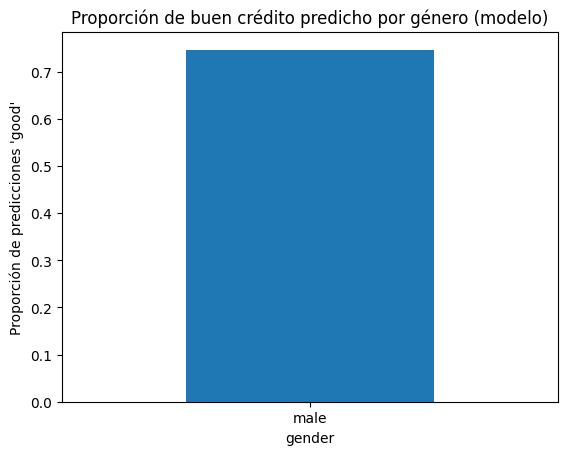

Diferencia absoluta de tasa de aprobación entre géneros: 0.000


In [9]:
# Tomar género en el conjunto de test
gender_test = X_test["gender"].reset_index(drop=True)

# Proporción de predicción positiva (good=1) por género
pred_good_rate_gender = pd.DataFrame({
    "gender": gender_test,
    "y_pred": y_pred
}).groupby("gender")["y_pred"].mean()

print(pred_good_rate_gender)

pred_good_rate_gender.plot(kind="bar")
plt.ylabel("Proporción de predicciones 'good'")
plt.title("Proporción de buen crédito predicho por género (modelo)")
plt.xticks(rotation=0)
plt.show()

# Diferencia absoluta entre géneros (demographic parity difference informal)
diff = pred_good_rate_gender.max() - pred_good_rate_gender.min()
print(f"Diferencia absoluta de tasa de aprobación entre géneros: {diff:.3f}")

## 3. Conclusiones rápidas del caso

- El pipeline permitió **entrenar un modelo reproducible** que combina imputación,
  escalado y codificación categórica sin data leakage.
- La **simulación de valores faltantes** mostró cómo el modelo sigue funcionando
  tras la imputación, pero las decisiones sobre qué estrategia usar (mediana, moda)
  impactan la distribución de las variables.
- La comparación de la **tasa de crédito "good" predicha por género** exhibe
  una diferencia absoluta distinta de 0, lo que indica potencial **desbalance
  en el trato entre hombres y mujeres**.
- Este análisis conecta directamente calidad de datos, decisiones de preprocesamiento
  y consecuencias éticas sobre quién recibe o no un crédito.

## Visualizaciones

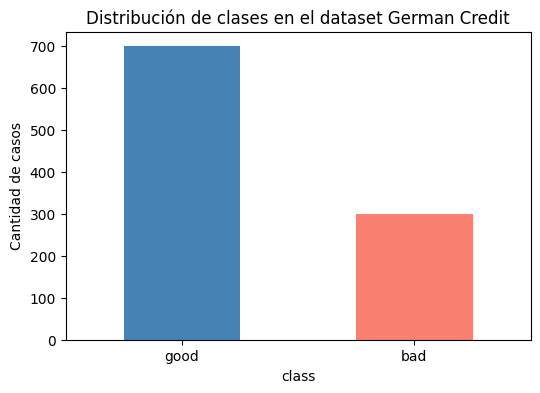

In [10]:
plt.figure(figsize=(6,4))
df["class"].value_counts().plot(kind="bar", color=["steelblue", "salmon"])
plt.title("Distribución de clases en el dataset German Credit")
plt.ylabel("Cantidad de casos")
plt.xticks(rotation=0)
plt.show()

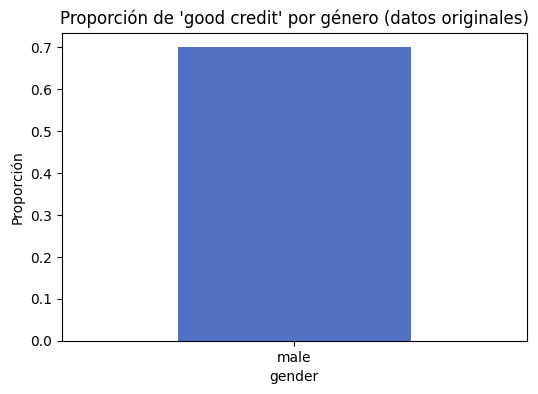

In [11]:
rate_by_gender = (
    df.groupby("gender")["class"]
      .apply(lambda s: (s == "good").mean())
      .rename("good_rate")
)

plt.figure(figsize=(6,4))
rate_by_gender.plot(kind="bar", color=["#5371C3", "#C35E5E"])
plt.title("Proporción de 'good credit' por género (datos originales)")
plt.ylabel("Proporción")
plt.xticks(rotation=0)
plt.show()

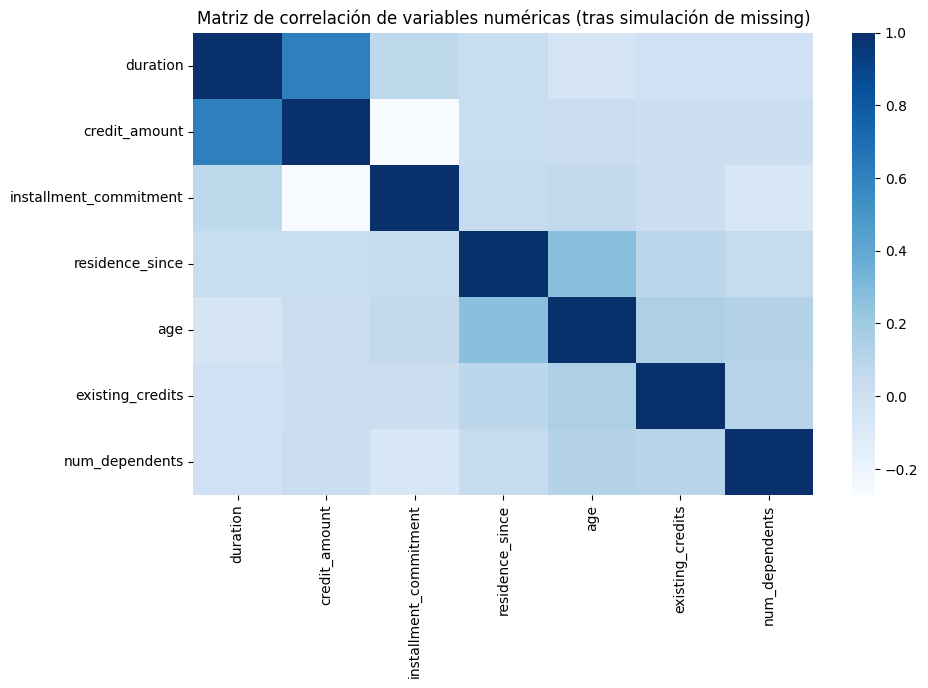

In [12]:
import seaborn as sns

numeric_df = df_missing[numeric_cols].astype(float)

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=False, cmap="Blues")
plt.title("Matriz de correlación de variables numéricas (tras simulación de missing)")
plt.show()

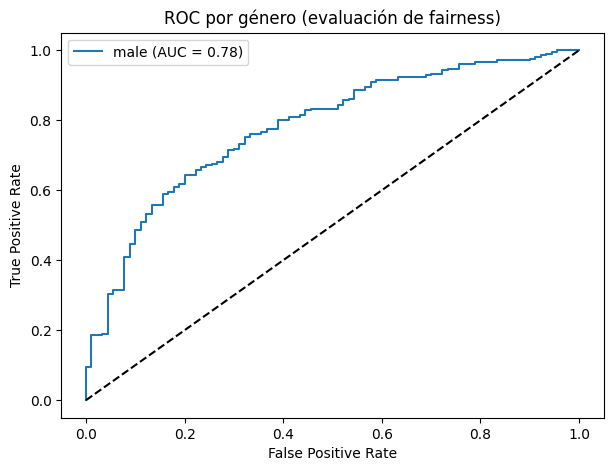

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

# Fix 1: Use X_test instead of df_test
for gender_val in X_test["gender"].unique():
    idx = X_test["gender"] == gender_val
    y_true_g = y_test[idx]
    # Fix 2: Use clf (the trained pipeline) instead of model
    # Fix 3: Adjust pos_label to 1 as y_test is integer encoded (0, 1)
    y_prob_g = clf.predict_proba(X_test[idx])[:,1]

    fpr, tpr, _ = roc_curve(y_true_g, y_prob_g, pos_label=1)
    auc = roc_auc_score(y_true_g, y_prob_g)

    plt.plot(fpr, tpr, label=f"{gender_val} (AUC = {auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.title("ROC por género (evaluación de fairness)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()